# Modeling with Regression models

In [6]:
import gc
import sys
sys.path.append('../')

import pandas as pd
import numpy as np


from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
%matplotlib inline


from src.fetch_data import DataLoader
from src.exploration import Analysis
from src.cleaning import CleanDataFrame
from src.visualization import Plotters
from src.processing import FeatureEngineering
from src.modeling_pipeline import (
    run_train_pipeline, 
    get_pipeline,
    )


import mlflow


cleaner = CleanDataFrame()
feature_engineering = FeatureEngineering()
plotters = Plotters(w=6, h=4)

# Getting the data

In [7]:
# Then load the raw sales data
data_path = 'data/merged/train.csv'
version = 'merged_v3'
repo = '../'

train_df = DataLoader.dvc_get_data(data_path, version, repo)
train_df['Date'] = pd.to_datetime(train_df['Date'])

# load the test data
# data_path = 'data/merged/test.csv'
# version = 'merged_v3'
# repo = '../'

# test_df = DataLoader.dvc_get_data(data_path, version, repo)
# test_df['Date'] = pd.to_datetime(test_df['Date'])

/home/hat/dev-env/10Acadamy/week_3/Rossmann-Pharmaceuticals-Sales-Forcast/notebooks/../src/fetch_data.py:28: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(io.StringIO(content), sep=",")
DataLoaderLogger - INFO - DVC: CSV file read with path: data/merged/train.csv | version: merged_v3 | from: ../


I will add the additional columns from the feature engineering here

In [8]:
train_df = feature_engineering.transform(train_df)


FeatureEngineeringLogger - INFO - 9 new columns added to the dataframe
FeatureEngineeringLogger - INFO - Feature enginerring completed


In order to properly split the data, we need the timeframe for it. I will grab all the unique dates in the `Date` column

In [9]:
timeframe = train_df.Date.unique()
timeframe.sort()
print(f"Starts at {timeframe[0]} --- ends at: {timeframe[-1]}")
print(f"It spans for {len(timeframe)} days")

Starts at 2013-01-01T00:00:00.000000000 --- ends at: 2015-07-31T00:00:00.000000000
It spans for 942 days


# Modeling

In [7]:
pipeline = get_pipeline(model=RandomForestRegressor(n_estimators=5, n_jobs=4), 
                        x=train_df.drop(columns=['Sales']))

In [8]:
pipeline

TrainingPipeline(steps=[('preprocessor',
                         ColumnTransformer(transformers=[('num',
                                                          Pipeline(steps=[('scale',
                                                                           StandardScaler())]),
                                                          ['Store', 'DayOfWeek',
                                                           'Customers', 'Open',
                                                           'Promo',
                                                           'SchoolHoliday',
                                                           'CompetitionDistance',
                                                           'CompetitionOpenSinceYear',
                                                           'Promo2',
                                                           'Promo2SinceWeek',
                                                           'Promo2SinceYear',
                                                           'DistanceToNextHoliday',
                                                           'DistanceFromPrevHoliday',
                                                           'Year', 'Month',
                                                           'We...
                                                                                                                        'is_month_end',
                                                                                                                        'is_month_start',
                                                                                                                        'is_quarter_end',
                                                                                                                        'is_quarter_start',
                                                                                                                        'is_year_end',
                                                                                                                        'is_year_start']}))]),
                                                          ['StateHoliday',
                                                           'StoreType',
                                                           'Assortment',
                                                           'CompetitionOpenSinceMonth',
                                                           'PromoInterval',
                                                           'is_month_end',
                                                           'is_month_start',
                                                           'is_quarter_end',
                                                           'is_quarter_start',
                                                           'is_year_end',
                                                           'is_year_start'])])),
                        ('model',
                         RandomForestRegressor(n_estimators=5, n_jobs=4))])

Specifying the n_jobs for the model object makes the training a lot smoother. Before I started to use it, my editor would crash since I was running out of ram.

In [16]:
train, val = train_df.iloc[:int(len(train_df)*.8), :], train_df.iloc[int(len(train_df)*.8):, :]

X_train = train.drop(columns=['Sales'])
X_val = val.drop(columns=['Sales'])
y_train = train['Sales'].values
y_val = val['Sales'].values


TrainingPipeline(steps=[('preprocessor',
                         ColumnTransformer(transformers=[('num',
                                                          Pipeline(steps=[('scale',
                                                                           StandardScaler())]),
                                                          ['Store', 'DayOfWeek',
                                                           'Customers', 'Open',
                                                           'Promo',
                                                           'SchoolHoliday',
                                                           'CompetitionDistance',
                                                           'CompetitionOpenSinceYear',
                                                           'Promo2',
                                                           'Promo2SinceWeek',
                                                           'Promo2SinceYear',
                                                           'DistanceToNextHoliday',
                                                           'DistanceFromPrevHoliday',
                                                           'Year', 'Month',
                                                           'We...
                                                                                                                        'is_month_end',
                                                                                                                        'is_month_start',
                                                                                                                        'is_quarter_end',
                                                                                                                        'is_quarter_start',
                                                                                                                        'is_year_end',
                                                                                                                        'is_year_start']}))]),
                                                          ['StateHoliday',
                                                           'StoreType',
                                                           'Assortment',
                                                           'CompetitionOpenSinceMonth',
                                                           'PromoInterval',
                                                           'is_month_end',
                                                           'is_month_start',
                                                           'is_quarter_end',
                                                           'is_quarter_start',
                                                           'is_year_end',
                                                           'is_year_start'])])),
                        ('model',
                         RandomForestRegressor(n_estimators=5, n_jobs=4))])

In [ ]:

pipeline.fit(X_train, y_train)

In [17]:
preds = pipeline.predict(X_val)

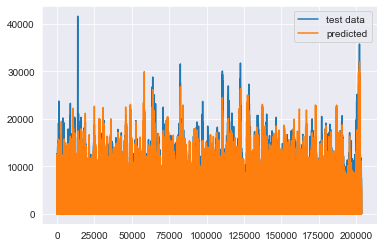

In [18]:
sns.lineplot(x=[*range(len(y_val))], y=y_val)
sns.lineplot(x=[*range(len(preds))], y=preds)
plt.legend(['test data', 'predicted'])

This does look promising

In [24]:
from sklearn.metrics import mean_squared_error, r2_score
sqrt_mse = np.sqrt(mean_squared_error(y_val, preds))
print(f"The Square root of our mean Squared error is: {sqrt_mse}")
r2 = r2_score(y_val, preds)
print(f"The R2-Score is: {r2}")

The Square root of our mean Squared error is: 1366.5814306254904
The R2-Score is: 0.8650541559076155


Text(0.5, 1.0, 'Sales outliers')

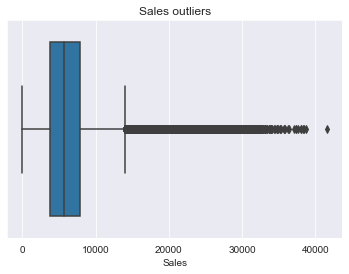

In [33]:
sns.boxplot(data=train_df, x='Sales')
plt.title("Sales outliers")

# Choosing a loss function

Since our Sales values do have outliers, I am going to chose Mean Squared Error as my loss function. 


# Training with my pipeline

{'mse': 339312.02, 'r2': 0.98, 'mae': 374.17}
Run params saved
Run metrics saved
figures saved with mlflow
saving dict
Run - run 1 | est-16 | depth-8 is logged to Experiment - Baseline-Regression-Model


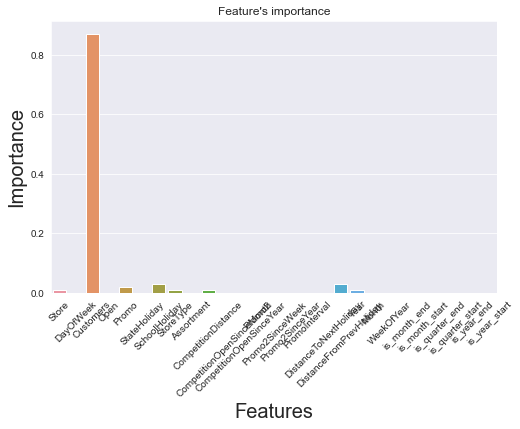

In [11]:
DEPTH = 8
ESTIMATORS = 16
mlflow.end_run()
model = RandomForestRegressor(
    n_estimators=DEPTH,
    max_depth=ESTIMATORS,
    n_jobs=4,
    random_state=77)
pipeline = run_train_pipeline(model=model,
                              x=train_df,
                              experiment_name='Baseline-Regression-Model',
                              run_name=f'run 1 | est-{ESTIMATORS} | depth-{DEPTH}')

mlflow.end_run()
